# Debugging:
## This script imports C and Python HDF output for comparison

In [3262]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import subprocess

# Labels and timestamps

In [3263]:
#####################################################
#
# C time tags. time-tag to convert.
# 
# time = '000' # initial condition
# time = '001' # before advect
# time = '002' # after advect
# time = '003' # after euler backward non-advective EXPL part
time = '004' # after euler backward non-advective IMPL part and hcenter, wplusx, wplusy debug
# time = '005' # after half-step
# time = '006' # after euler-forward non-advective
# time = '007' # after FULL advect
# time = '008'# after FULL euler backward non-advective EXPL part
# time = '009' # after full-step
#
#####################################################

#####################################################
#
# Python time labels
#
# label = '000'
# label = 'before_flux'
# label = 'before_advect'
# label = 'after_advect'
# label = 'after_ebnaexp'
label = 'after_ebnaimp'
# label = 'after_half_step'
# label = 'after_efna'
# label = 'after_full_advect'
# label = 'after_full_ebnaexp'
# label = 'after_full_step'
#
#####################################################

#####################################################
#
# C-output folder names
#
base_suffix = '_acoustic_wave_high/'
# base_suffix = '_internal_long_wave/'
# base_suffix = '_travelling_vortex_3d_48_no_initial_projection/'
# base_suffix = '_travelling_vortex_3d_48_with_initial_projection/'
#
#####################################################

#####################################################
#
# and its filename
#
py_filename = "output_acoustic_wave_high_low_mach_gravity_comp.h5"
# py_filename = "output_internal_long_wave_low_mach_gravity_comp.h5"
# py_filename = "output_travelling_vortex_3d_48_low_mach_gravity_comp.h5"
#
#####################################################

figsize_tuple = (12,3)

## Converter

Converts all hdf4 output of RKLM C-code to hdf5.

In [3264]:
base_folder_name = "output"

base_path = base_folder_name + base_suffix
folder_comp = "low_Mach_gravity_comp/"
folder_psinc = "low_Mach_gravity_psinc/"

# Manually list the folder names for each output
directories = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_nodes', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
directories += ['rhou', 'rhov', 'rhow', 'rhs']

# And manually list the file names.
filenames = ['S', 'T', 'Y', 'buoy', 'dT', 'dY', 'dp2_c', 'dp2_n', 'dpdim', 'drhoY', 'p', 'p2_c', 'p2_n', 'rho', 'rhoY', 'rhoe', 'u', 'v', 'vortz', 'w']
filenames += ['rhou', 'rhov', 'rhow', 'rhs']

# specify the format extensions for input and output of converter
hdf_format = '.'+ 'hdf'
h5_format = '.' + 'h5'

if time == '001' or time == '005':
    directories += ['flux_x', 'flux_y']
    filenames += ['rhoYu', 'rhoYv']

if time == '004':
    directories += ['wplusx', 'wplusy', 'hcenter', 'pnew', 'rhs_nodes', 'p2_initial']
    filenames += ['wplusx', 'wplusy', 'hcenter', 'p2_full', 'rhs_nodes', 'p2_initial']

string_hdf = '_' + time + hdf_format
string_h5 = '_' + time + h5_format
full_path = base_path + folder_comp

lst_hdf = []
lst_h5 = []

# build list of paths from parameters specified above.
i = 0
for directory in directories:
    lst_hdf.append(full_path + directory + '/' + filenames[i] + string_hdf)
    lst_h5.append(full_path + directory + '/' + filenames[i] + string_h5)
    i += 1 

# print the list of paths
for path in lst_hdf:
    print(path)

# now, convert the arrays specified in the list of paths
for item in lst_hdf:
    p = subprocess.call(["./h4toh5convert", item])

output_acoustic_wave_high/low_Mach_gravity_comp/S/S_004.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/T/T_004.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/Y/Y_004.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/buoy/buoy_004.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/dT/dT_004.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/dY/dY_004.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/dp2_c/dp2_c_004.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/dp2_nodes/dp2_n_004.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/dpdim/dpdim_004.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/drhoY/drhoY_004.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/p/p_004.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/p2_c/p2_c_004.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/p2_nodes/p2_n_004.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/rho/rho_004.hdf
output_acoustic_wave_high/low_Mach_gravity_comp/rhoY/rhoY_004.hdf
output_acoustic_wave_high/lo

## Import C hdf5 output

Import the test case arrays from the c-output.

In [3265]:
# manually specific folder names
test_cases_folders = ['p2_c', 'dp2_nodes', 'p', 'p2_nodes', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u', 'vortz', 'dpdim', 'T', 'dT', 'Y', 'dY', 'dp2_c']
# test_cases_folders += ['debug', 'debug', 'debug']

test_cases_folders += ['rhs']

# and filenames
test_cases_names = ['p2_c', 'dp2_n', 'p', 'p2_n', 'rho', 'rhoY', 'rhoe', 'rhou', 'rhov', 'rhow', 'u', 'vortz', 'dpdim', 'T', 'dT', 'Y', 'dY', 'dp2_c']

test_cases_names += ['rhs']

if time == '001' or time == '005':
    test_cases_folders += ['flux_x','flux_y']
    test_cases_names += ['rhoYu', 'rhoYv']

if time == '004':
    test_cases_folders += ['wplusx', 'wplusy', 'hcenter', 'pnew', 'rhs_nodes', 'p2_initial']
    test_cases_names += ['wplusx', 'wplusy', 'hcenter', 'p2_full', 'rhs_nodes', 'p2_initial']
    
test_cases_folders = np.char.array(test_cases_folders)
test_cases_names = np.char.array(test_cases_names)
    
# build paths from folder names and filenames
test_cases_paths = full_path + test_cases_folders + '/' + test_cases_names + string_h5

# define empty class as a holder for all the C-hdf5 output.
class c_output(object):
    def __init__(self):
        None
        
    def c_out(self):
        for key,value in vars(self).items():
            setattr(self,key,value['Data-Set-2'])

## Import the Python output

In [3266]:
# specify directory where the python hdf5 output is.
# py_directory = "../RKLM_Python/"
py_directory = "../"

py_path = py_directory + py_filename

# helper function to extract array from hdf file by its name and timestep

label = '_' + label
def py_out(py_dataset,time=label):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

## Helper diagnostic functions

In [3267]:
# print an array
def p(obj):
    print(obj)
    
# visualise an array
def v(obj):
    plt.imshow(obj)
    plt.colorbar()
    plt.show()
    
# plot a slice of the array, default is x = 0 for all y (slice at origin)
def s(obj,slc=(slice(None))):
    plt.plot(obj['Data-Set-2'][slc])
    plt.show()
    
# plot the difference between the C and Python outputs
def diff(obj_c, obj_py, title, option = None):
#     obj_c = obj_c[2:-2,2:-2]
#     obj_c -= obj_c.mean()
#     obj_py = obj_py[2:-2,2:-2]
#     obj_py -= obj_py.mean()
#     
    c_range = np.max(obj_c) - np.min(obj_c)
    py_range = np.max(obj_py) - np.min(obj_py)
    if option == None:
        max_norm = np.abs(obj_c - obj_py)
    else:
        max_norm = (obj_c - obj_py)
    
    max_diff = np.max(max_norm)
    
    fig, ax = plt.subplots(ncols=3, figsize=figsize_tuple)
    # plot c array
    im_c = ax[0].pcolor(obj_c, label="c")
    fig.colorbar(im_c,ax=ax[0])
    ax[0].set_title("c")
    ax[0].set_aspect('auto')
    
    # plot python array
    im_py = ax[1].pcolor(obj_py, label="py")
    fig.colorbar(im_py,ax=ax[1])
    ax[1].set_title("py")
    ax[1].set_aspect('auto')

    # plot the difference between the two
    im_diff = ax[2].pcolor(max_norm, label="diff")
    fig.colorbar(im_diff,ax=ax[2])
    ax[2].set_title("diff")
    ax[2].set_aspect('auto')
    
    # calculate the max difference relative to the C-output for non-zero values.
    if c_range == 0.0:
        rel_diff = 0.0
    else:
        rel_diff = max_diff/c_range
        
    print("comparison = %s,\nc_range = %e, py_range = %e, \nmax diff = %e, rel. diff = %e," %(title, c_range, py_range, max_diff, rel_diff))
    plt.tight_layout(h_pad=1)
    plt.show()
    print("################################################## \n")

In [3268]:
# get an instance of an empty class to populate it with the C-HDF output as attributes
c = c_output()

# populate the class with the C-HDF output as attributes
i = 0
for path in test_cases_paths:
    setattr(c,test_cases_folders[i],h5py.File(path, 'r'))
    i += 1
    
    
# run the method to extract array from HDF objects
c.c_out()

In [3269]:
# # open the Python HDF file
# pyfile = h5py.File(py_path, 'r')

# # print(py_out('wplusx'))

# # print(c.pnew[:])
# # print(py_out('p2')[:])

# # diff(c.wplusx,py_out('wplusx'),'wplusx')
# # diff(c.wplusy,py_out('wplusy'),'wplusy')
# # diff(c.hcenter,py_out('hcenter'),'hcenter')
# # diff(c.pnew,py_out('p2'),'p2')
# # diff(c.pnew,py_out('p2'),'p2')


# # inner_domain = np.empty((2), dtype=object)
# # inner_domain = (slice(2,50),slice(2,50))
# # reshaper = c.wplusx[:].reshape(-1,)
# # reshaper = reshaper[:53**2]
# # reshaper = reshaper.reshape(53,53)
# # inner_domain = (slice(None,), slice(None,))
# # # print(c.wplusx[:][inner_domain].shape)
# # # plt.imshow(c.wplusx[:][inner_domain])
# # print(reshaper.shape)
# # plt.imshow(reshaper)
# # plt.colorbar()
# # plt.show()

# # plt.imshow(c.wplusy[:])
# # plt.colorbar()
# # plt.show()

# # plt.imshow(py_out('wplusx'))
# # plt.colorbar()
# # plt.show()

# plt.imshow(c.pnew[:])
# plt.colorbar()
# plt.show()

# pyfile.close()

comparison = p2_full,
c_range = 2.017659e+04, py_range = 2.023854e+04, 
max diff = 2.219142e+03, rel. diff = 1.099860e-01,


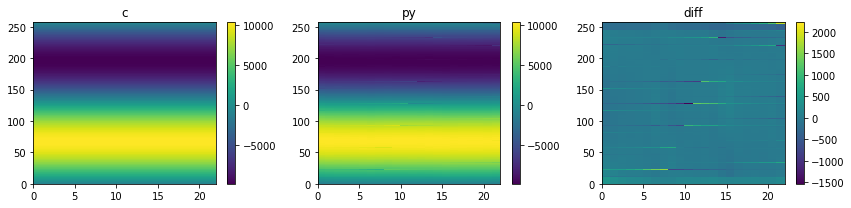

################################################## 

comparison = rhs_nodes,
c_range = 1.799947e+08, py_range = 1.799947e+08, 
max diff = 0.000000e+00, rel. diff = 0.000000e+00,


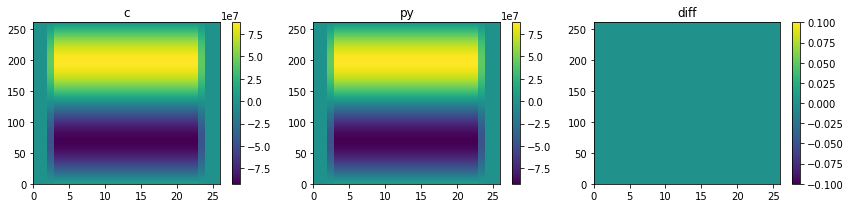

################################################## 

comparison = p2_initial,
c_range = 2.026500e+04, py_range = 2.026500e+04, 
max diff = 0.000000e+00, rel. diff = 0.000000e+00,


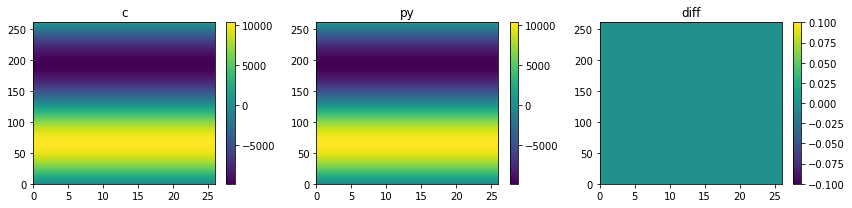

################################################## 

comparison = p2_nodes,
c_range = 2.017659e+04, py_range = 2.023854e+04, 
max diff = 2.219142e+03, rel. diff = 1.099860e-01,


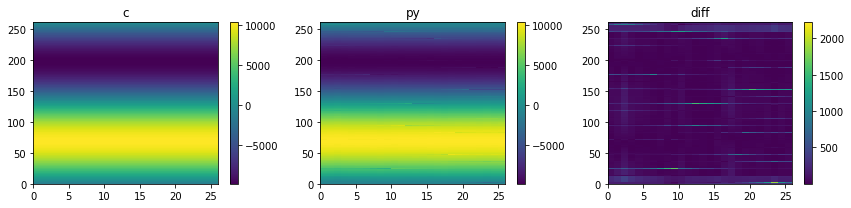

################################################## 

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0 128 128 128 128 128 128 128 128 128 128 128 128 128 128
 128 128 128 128 128 128 128 128 256 256 256 256 256 256 256 256 256 256
 256 256 256 256 256 256 256 256 256 256 256 256]


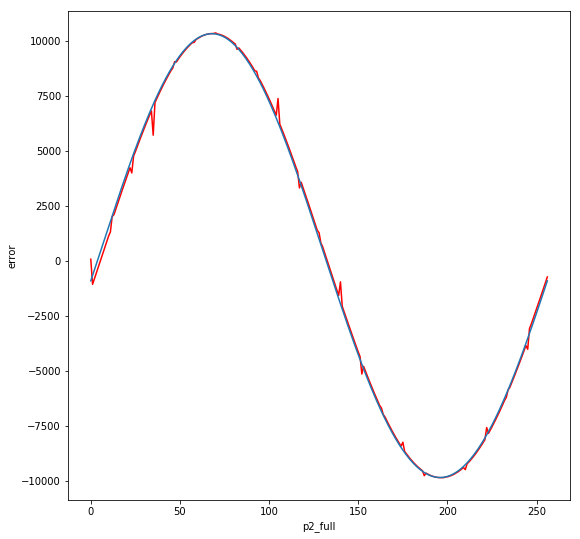

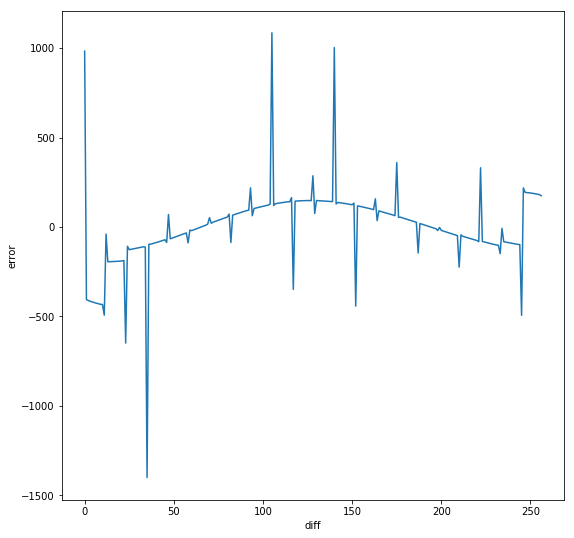

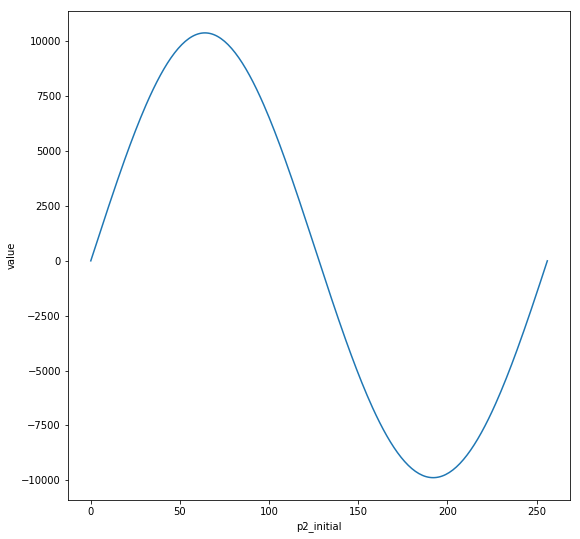

[497.7881 497.7881 497.7881 497.7881 497.7881 497.7881 497.7881 497.7881
 497.7881 497.7881]


In [3288]:
# open the Python HDF file
pyfile = h5py.File(py_path, 'r')

# make comparisons for the arrays.
# Arguments: C-array (class attribute), Python-array (numpy array), and a title.
# PPP = np.copy(py_out('dp2_nodes'))
# PPP[:,-4:-2] = py_out('dp2_nodes')[:,2:4][::-1]

# diff(c.pnew, PPP, 'dp2_nodes')

inner = (slice(2,-2),slice(2,-2))
if time == '004':
#     diff(c.hcenter, py_out('hcenter'), 'hcenter')
#     diff(c.wplusx, py_out('wplusx'), 'wplusx')
#     diff(c.wplusy, py_out('wplusy'), 'wplusy')
    diff(c.pnew[inner], py_out('p2_full')[inner], 'p2_full', option='na')
    diff(c.rhs_nodes, py_out('rhs_nodes'), 'rhs_nodes')
    diff(c.p2_initial, py_out('p2_initial'), 'p2_initial')
    
if time == '001' or time == '005':
    diff(c.flux_x, py_out('rhoYu').T, 'rhoYu')
    diff(c.flux_y, py_out('rhoYv').T, 'rhoYv')

# diff(c.pnew,py_out('dp2_nodes'),'dp2_nodes')
# diff(c.rhs, py_out('rhs'), 'rhs')
diff(c.p2_nodes,py_out('p2_nodes'),'p2_nodes')
# diff(c.dp2_c,py_out('dp2_cells'),'dp2_cells')
# diff(c.p2_c,py_out('p2_cells'),'p2_cells')

# diff(c.rho,py_out('rho'),'rho')
# # diff(c.rhoe,py_out('rhoe'),'rhoe')
# diff(c.rhoY,py_out('rhoY'),'rhoY')

# diff(c.rhou,py_out('rhou'),'rhou')
# # print(np.argmax(np.abs(c.rhou - py_out('rhou'))))
# diff(c.rhov,py_out('rhov'),'rhov', option='na')
# diff(c.rhow,py_out('rhow'),'rhow')

# diff(c.u, py_out('u'), 'u')
# diff(c.p, py_out('p'), 'p')
# diff(c.dpdim, py_out('dpdim'), 'dpdim')
# diff(c.vortz, py_out('vortz'), 'vortz')

# diff(c.T, py_out('T'), 'T')
# diff(c.dT, py_out('dT'), 'dT')

# diff(c.Y, py_out('Y'), 'Y')
# diff(c.dY, py_out('dY'), 'dY')

# print(c.hcenter[:][2:-2,2:-2])
# print(py_out('hcenter')[2:-2,2:-2])

print(np.where(py_out('p2_initial')[inner] == 0.)[0])

if time == '004':
    idx = 0
    fig = plt.figure(figsize=(9,9))
    plt.plot(py_out('p2_full')[inner][:,idx], 'r')
    plt.plot(c.pnew[inner][:,7])
    plt.xlabel('p2_full')
    plt.ylabel('error')
    plt.show()

    fig = plt.figure(figsize=(9,9))
    plt.plot((py_out('p2_full') - c.pnew)[inner][:,idx])
    plt.xlabel('diff')
    plt.ylabel('error')
    plt.show()
    
    fig = plt.figure(figsize=(9,9))
    plt.plot((py_out('p2_initial')[inner])[:,7])
    plt.xlabel('p2_initial')
    plt.ylabel('value')
    plt.show()
    
    print(py_out('p2_initial')[inner][2,:][:10])
    
if time == '002':
    idx = 1
    fig = plt.figure(figsize=(9,9))
    plt.plot(py_out('rhou')[:,idx],'r')
    plt.plot(c.rhou[:,idx],'k')
    plt.title('rhou, sliced at idx %i' %idx )
    plt.ylabel('rhou')
    plt.xlabel('x')
    plt.show()
    
    fig = plt.figure(figsize=(9,9))
    plt.plot((py_out('rhou') - c.rhou)[:,idx])
    plt.title('difference in rhou outputs, sliced at idx %i' %idx )
    plt.xlabel('diff')
    plt.ylabel('error')
    plt.show()
    
    
if time == '007':
    fig = plt.figure(figsize=(9,9))
    plt.plot((py_out('p2_nodes') - c.p2_nodes)[:,idx])
    plt.title('difference in p2_nodes outputs, sliced at idx %i' %idx )
    plt.xlabel('diff')
    plt.ylabel('error')
    plt.show()
    
if time == '005':
    fig = plt.figure(figsize=(9,9))
    plt.plot((py_out('rhoYu').T - c.flux_x)[:,idx])
    plt.title('difference in rhoYu outputs, sliced at idx %i' %idx )
    plt.xlabel('diff')
    plt.ylabel('error')
    plt.show()

pyfile.close()

In [3271]:
# directory = 'debug'
# filename = 'Lefts'
# time = '_003'
# string_hdf = time + '.hdf'
# string_h5 = time + '.h5'
# item = full_path + directory + '/' + filename + string_hdf


# subprocess.call(["./h4toh5convert", item])
# item_h5 = full_path + directory + '/' + filename + string_h5


# Lefts_rhou = h5py.File(item_h5, 'r')
# Lefts_rhou = Lefts_rhou['Data-Set-2'][:]

# label0 = '_003'
# def py_out0(py_dataset,time=label0):
#     return pyfile[str(py_dataset)][str(py_dataset)+time][:]

# pyfile = h5py.File(py_path, 'r')
# p_Lefts_rhou = py_out0('Lefts_rhou')
# pyfile.close()
# # 
# plt.figure(figsize = (10,8))
# plt.imshow(Lefts_rhou)
# plt.show()
# plt.imshow(p_Lefts_rhou)
# plt.show()
# plt.imshow(np.abs(Lefts_rhou - p_Lefts_rhou.T))

# pyfile.close()

In [3272]:
# directory = 'flux_x'
# filename = 'rhoY'
# time = '_000'
# string_hdf = time + '.hdf'
# string_h5 = time + '.h5'
# item = full_path + directory + '/' + filename + string_hdf


# subprocess.call(["./h4toh5convert", item])
# item_h5 = full_path + directory + '/' + filename + string_h5

# Sol_rhoY = h5py.File(item_h5, 'r')
# Sol_rhoY = Sol_rhoY['Data-Set-2'][:]

# directory = 'flux_x'
# filename = 'rhou'
# time = '_000'
# string_hdf = time + '.hdf'
# string_h5 = time + '.h5'
# item = full_path + directory + '/' + filename + string_hdf


# subprocess.call(["./h4toh5convert", item])
# item_h5 = full_path + directory + '/' + filename + string_h5

# Sol_rhou = h5py.File(item_h5, 'r')
# Sol_rhou = Sol_rhou['Data-Set-2'][:]

# directory = 'flux_x'
# filename = 'rho'
# time = '_000'
# string_hdf = time + '.hdf'
# string_h5 = time + '.h5'
# item = full_path + directory + '/' + filename + string_hdf


# subprocess.call(["./h4toh5convert", item])
# item_h5 = full_path + directory + '/' + filename + string_h5

# Sol_rho = h5py.File(item_h5, 'r')
# Sol_rho = Sol_rho['Data-Set-2'][:]


# directory = 'rhoY'
# filename = 'rhoY'
# time = '_000'
# string_hdf = time + '.hdf'
# string_h5 = time + '.h5'
# item = full_path + directory + '/' + filename + string_hdf

# subprocess.call(["./h4toh5convert", item])
# item_h5 = full_path + directory + '/' + filename + string_h5

# Sol_rhoYY = h5py.File(item_h5, 'r')
# Sol_rhoYY = Sol_rhoYY['Data-Set-2'][:]

# pyfile = h5py.File(py_path, 'r')
# p_rhoY = py_out('rhoY')
# pyfile.close()

# pyfile = h5py.File(py_path, 'r')
# p_rhou = py_out('rhou')
# pyfile.close()

# pyfile = h5py.File(py_path, 'r')
# p_rho = py_out('rho')
# pyfile.close()

# plt.imshow(Sol_rhoY[1:-1,1:-1])
# plt.show()
# plt.imshow(Sol_rhoYY[1:-1,1:-1])
# plt.show()
# plt.imshow(p_rhoY[1:-1,1:-1])
# plt.show()

# plt.imshow(Sol_rhou[1:-1,1:-1])
# plt.show()
# plt.imshow(p_rhou[1:-1,1:-1])
# plt.show()

# plt.imshow(Sol_rho[1:-1,1:-1])
# plt.show()
# plt.imshow(p_rho[1:-1,1:-1])
# plt.show()


# plt.imshow(Sol_rhoY - p_rhoY)
# plt.show()
# plt.imshow(Sol_rhou - p_rhou)
# plt.colorbar()
# plt.show()
# plt.imshow(Sol_rho - p_rho)
# plt.show()

In [3273]:
# directory = 'flux_x'
# filename = 'rhoYu'
# time = '_000'
# string_hdf = time + '.hdf'
# string_h5 = time + '.h5'
# item = full_path + directory + '/' + filename + string_hdf


# subprocess.call(["./h4toh5convert", item])
# item_h5 = full_path + directory + '/' + filename + string_h5

# array = h5py.File(item_h5, 'r')
# array = array['Data-Set-2'][:]

# plt.imshow(array)
# plt.colorbar()
# plt.show()
# print(array.shape)
# print(array.max(), array.min())
# print(np.argmax(array.flatten()))

# pyfile = h5py.File(py_path, 'r')

# p_array = py_out('rhoYu','_000')

# plt.imshow(p_array)
# plt.colorbar()
# plt.show()
# print(p_array.T.shape)
# print(p_array.max(), p_array.min())
# print(np.argmax(p_array))

# plt.imshow(np.abs(array - p_array.T))
# print("argmax diff = ", np.argmax(np.abs(array - p_array.T)))
# print("max diff = ", np.max(np.abs(array - p_array.T)))
# plt.colorbar()
# plt.show()


# # print(array[2])
# # print(p_array.T[2])

# print(array[-2])
# print(p_array.T[-2])

# directory = 'flux_y'
# filename = 'rhoYv'
# time = '_000'
# string_hdf = time + '.hdf'
# string_h5 = time + '.h5'
# item = full_path + directory + '/' + filename + string_hdf


# subprocess.call(["./h4toh5convert", item])
# item_h5 = full_path + directory + '/' + filename + string_h5

# array = h5py.File(item_h5, 'r')
# array = array['Data-Set-2'][:]

# plt.imshow(array)
# plt.colorbar()
# plt.show()
# print(array.max())

# p_array = py_out('rhoYv','_000')

# plt.imshow(p_array)
# plt.colorbar()
# plt.show()
# print(p_array.max())
# print(p_array.shape)

# plt.imshow(np.abs(array - p_array.T))
# plt.colorbar()
# plt.show()

# print("argmax diff = ", np.argmax(np.abs(array - p_array.T)))
# print("max diff = ", np.max(np.abs(array - p_array.T)))

# pyfile.close()

In [3274]:
pyfile.close()

In [3275]:
for i in range(2,3):
    print(i)
    
(-0.06056165571350958)**0.5

2


(1.506883668457318e-17+0.24609277866997556j)

In [3276]:
AA = np.zeros((5,5))
print(AA)
print(np.all(AA))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
False


In [3277]:
rhoYu_cm =  0.9999511114038965
rhoYu_mm =  1.0003473979573558
rhoYu_cc =  0.9999842804036515
rhoYu_mc =  1.000166296189299
rhoYu_cp =  1.000010487506917
rhoYu_mp =  0.9999252581338697

rhoYu_m = 0.5*(rhoYu_cm+rhoYu_mm)
rhoYu_c = 0.5*(rhoYu_cc+rhoYu_mc)
rhoYu_p = 0.5*(rhoYu_cp+rhoYu_mp)

ans = 0.25*(rhoYu_m + 2.0*rhoYu_c + rhoYu_p)
print(ans)

print(1.000066911014053 - ans)

1.0000669260234925
-1.500943946908251e-08


In [3278]:
rhoYu_cm = 1.0001662778213436
rhoYu_mm = 1.0008170447231102
rhoYu_cc = 0.99992526849323593
rhoYu_mc = 0.99961879109867247
rhoYu_cp = 0.999712348255824
rhoYu_mp = 0.99851134117611362

rhoYu_m = 0.5*(rhoYu_cm+rhoYu_mm)
rhoYu_c = 0.5*(rhoYu_cc+rhoYu_mc)
rhoYu_p = 0.5*(rhoYu_cp+rhoYu_mp)

ans = 0.25*(rhoYu_m + 2.0*rhoYu_c + rhoYu_p)
print(ans)

0.9997868913950261
